In [5]:
import numpy as np
from typing import Union
from glob import glob
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import skimage

<ipython-input-6-0133adacb678>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


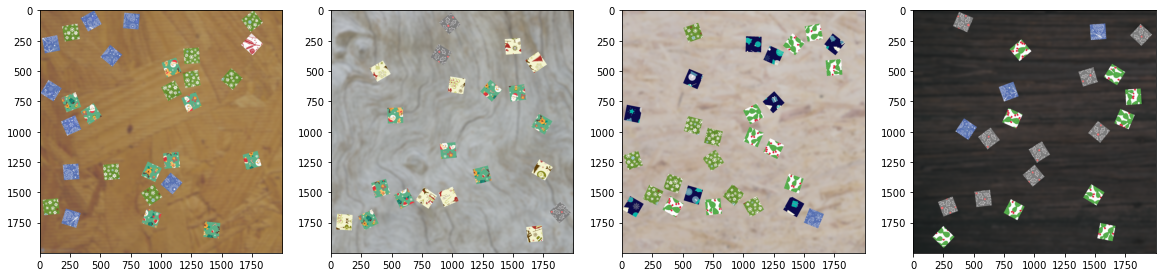

In [6]:
def load_input_image(image_index ,  folder ="train2" , path = "data_project"):
    
    filename = "train_{}.png".format(str(image_index).zfill(2))
    path_solution = os.path.join(path,folder , filename )
    
    im= Image.open(os.path.join(path,folder,filename)).convert('RGB')
    im = np.array(im)
    return im

input_ims = [load_input_image(image_index=i) for i in range(12)]
#plt.imshow(input_ims[0])
fig, axs = plt.subplots(ncols=4,figsize=(20,5))
for i in range(4):
    axs[i].imshow(input_ims[i])
fig.show()

## Task 1: Pieces segmentation

### Edge detection with Gaussian filter

In [8]:
from scipy.ndimage import convolve, gaussian_filter, gaussian_laplace, sobel
from skimage.color import rgb2gray

def zero_crossing(img,threshold =-0.05):
    w, h = img.shape
    out = np.zeros_like(img)
    for x in range(1,w-1):
        for y in range(1,h-1):
            window = img[x-1:x+2,y-1:y+2]
            point = img[x,y]
            wmax = window.max()
            wmin = window.min()
            if point==0.0 and wmax>0.0 and wmin<0.0:
                zeroCross=1
            elif point>0.0:
                zeroCross= True if wmin<0.0 else False
            else:
                zeroCross= True if wmin<0.0 else False
            if (wmax-wmin)>threshold and zeroCross:
                out[x,y] = 1
    return out

def scaler(img):
    Max = max(img.ravel())
    return img/Max

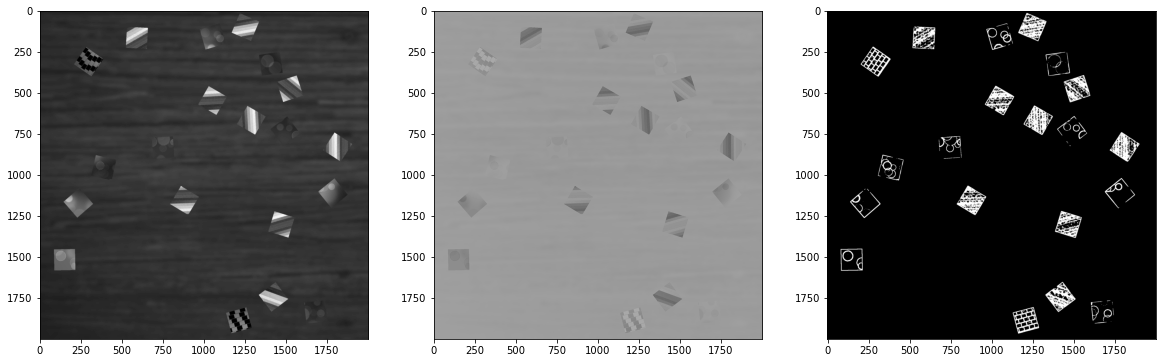

In [156]:
im = input_ims[4]
im_gray = rgb2gray(im)
#filtered_im = gaussian_filter(im_gray,sigma=1)
filtered_im = scaler(gaussian_laplace(im_gray,sigma=0.5))

fig, axs = plt.subplots(ncols=3,figsize=(20,7))
axs[0].imshow(im_gray,cmap='gray')
axs[1].imshow(filtered_im,cmap='gray')
axs[2].imshow(zero_crossing(filtered_im,0.05),cmap='gray')

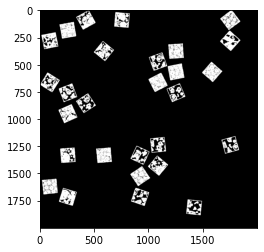

In [9]:
def highlight_pieces(img):
    filtered_img = scaler(gaussian_laplace(img/256,sigma=1))
    mask = np.zeros_like(img)
    mask[:,:,0] = zero_crossing(filtered_img[:,:,0],0.05)
    mask[:,:,1] = zero_crossing(filtered_img[:,:,1],0.05)
    mask[:,:,2] = zero_crossing(filtered_img[:,:,2],0.05)
    mask = np.amax(mask,axis=2)
    return mask

mask = highlight_pieces(input_ims[0])
plt.imshow(mask,cmap='gray')

In [21]:
import cv2

def get4n(x, y, shape):
    out = []
    maxx = shape[0]-1
    maxy = shape[1]-1
    #top center
    outx = x
    outy = min(max(y-1,0),maxy)
    out.append((outx,outy))
    #left
    outx = min(max(x-1,0),maxx)
    outy = y
    out.append((outx,outy))
    #right
    outx = min(max(x+1,0),maxx)
    outy = y
    out.append((outx,outy))
    #bottom center
    outx = x
    outy = min(max(y+1,0),maxy)
    out.append((outx,outy))
    return out

def region_growing(img, seed, processed):
    seed_points = []
    outimg = np.zeros_like(img)
    seed_points.append((seed[0], seed[1]))
    while(len(seed_points) > 0):
        pix = seed_points[0]
        outimg[pix[0], pix[1]] = 1
        for coord in get4n(pix[0], pix[1], img.shape):
            if img[coord[0], coord[1]] != 0:
                outimg[coord[0], coord[1]] = 1
                if processed[coord[0]][coord[1]]==False:
                    seed_points.append(coord)
                processed[coord[0]][coord[1]] = True
        seed_points.pop(0)
    return outimg

def region_labelling(img, seed, labels, value):
    seed_points = []
    seed_points.append((seed[0], seed[1]))
    pixels = []
    while(len(seed_points) > 0):
        pix = seed_points[0]
        for coord in get4n(pix[0], pix[1], img.shape):
            if img[coord[0],coord[1]] != 0:
                if labels[coord[0]][coord[1]]==0:
                    seed_points.append(coord)
                    #pixels.append(coord)
                labels[coord[0]][coord[1]] = value
        seed_points.pop(0)


def extract_objects(image):
    labels = np.zeros_like(image)
    #obj_list = []
    I, J = image.shape
    max_label = 0
    for i in range(I):
        for j in range(J):
            if image[i][j]>0 and labels[i][j]==0:
                region_labelling(img=image,seed=[i,j],labels=labels,value=max_label+1)
                max_label+=1
    #obj_list = [np.array()]
    return labels

In [10]:
im = input_ims[0]
mask = highlight_pieces(im)

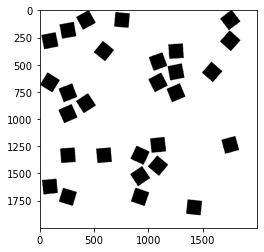

In [13]:
processed = np.zeros_like(mask)
bg = region_growing(1-mask,[0,0],processed)
plt.imshow(bg,cmap='gray')

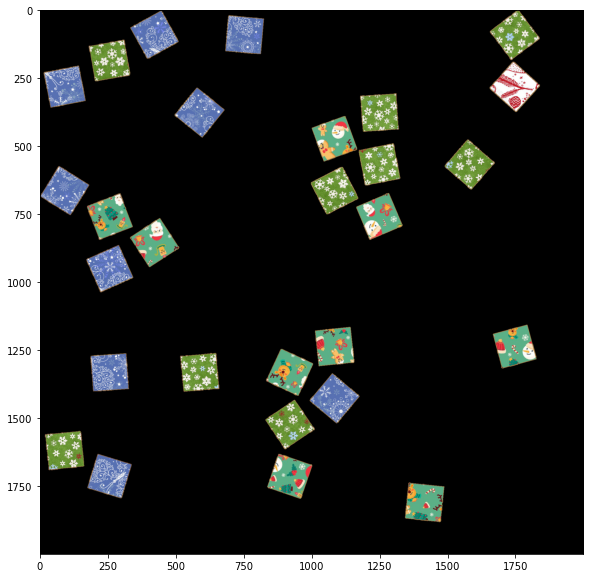

In [212]:
pieces = im * (1-np.dstack((bg,bg,bg)))
plt.figure(figsize=(10,10))
plt.imshow(pieces)

In [22]:
labels = extract_objects(1-bg)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]


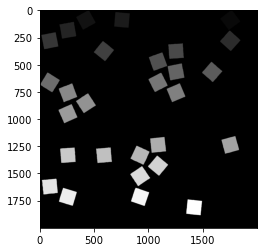

In [23]:
print(np.unique(labels.ravel()))
plt.imshow(labels,cmap='gray')

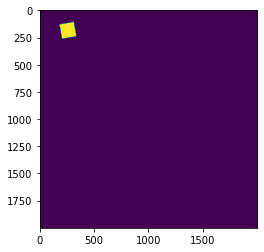

In [45]:
pieces_list = [np.where(labels == i) for i in np.unique(labels.ravel())[1:]]
#index = np.where(labels == 1)
pieces_list = [list(zip(index[0],index[1])) for index in pieces_list]
sample_img = np.zeros_like(bg)
for i,j in pieces_list[3]:
    sample_img[i,j] = 1
plt.imshow(sample_img)

In [50]:
piece = pieces_list[0]
print(len(piece))

17822
